In [3]:
import ensaio
import pandas as pd
import pyproj
import harmonica as hm
import numpy as np
import verde as vd
import itertools
from RIS_gravity_inversion import utils

In [4]:
fname = ensaio.fetch_bushveld_gravity(version=1)
data = pd.read_csv(fname)

projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.values.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)

coordinates = (easting, northing, data.height_geometric_m.values)

Number of combinations: 16
Combinations: [{'damping': 0.01, 'depth': 5000.0}, {'damping': 0.01, 'depth': 10000.0}, {'damping': 0.01, 'depth': 20000.0}, {'damping': 0.01, 'depth': 50000.0}, {'damping': 0.1, 'depth': 5000.0}, {'damping': 0.1, 'depth': 10000.0}, {'damping': 0.1, 'depth': 20000.0}, {'damping': 0.1, 'depth': 50000.0}, {'damping': 1, 'depth': 5000.0}, {'damping': 1, 'depth': 10000.0}, {'damping': 1, 'depth': 20000.0}, {'damping': 1, 'depth': 50000.0}, {'damping': 10, 'depth': 5000.0}, {'damping': 10, 'depth': 10000.0}, {'damping': 10, 'depth': 20000.0}, {'damping': 10, 'depth': 50000.0}]
Best score: 0.919726173084614
Best parameters: {'damping': 1, 'depth': 10000.0}


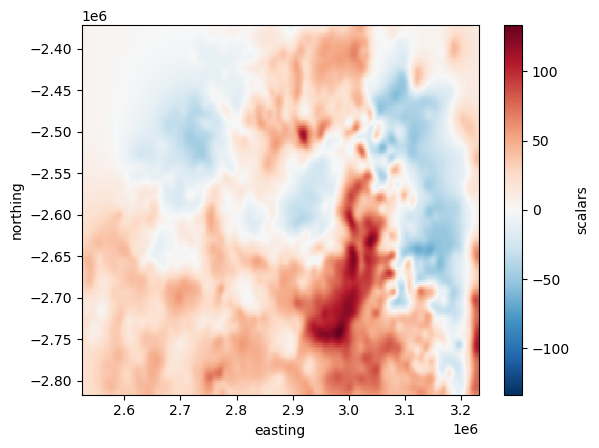

In [5]:
dampings = [0.01, 0.1, 1, 10,]
depths = [5e3, 10e3, 20e3, 50e3]

parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))
print("Combinations:", parameter_sets)

equivalent_sources = hm.EquivalentSources()

scores = []
for params in parameter_sets:
    equivalent_sources.set_params(**params)
    score = np.mean(
        vd.cross_val_score(
            equivalent_sources,
            coordinates,
            data.gravity_disturbance_mgal,
        )
    )
    scores.append(score)
    
best = np.argmax(scores)
print("Best score:", scores[best])
print("Best parameters:", parameter_sets[best])

eqs_best = hm.EquivalentSources(**parameter_sets[best]).fit(
    coordinates, data.gravity_disturbance_mgal
)
# Define grid coordinates
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=2e3,
    extra_coords=2.5e3,
)

grid = eqs_best.grid(grid_coords)
grid.scalars.plot()

[I 2023-04-19 13:56:04,018] A new study created in Journal with name: tmp


Optimizing:   0%|          | 0/40 [00:00<?, ?it/s]

FrozenTrial(number=38, state=TrialState.COMPLETE, values=[0.9208058481678643], datetime_start=datetime.datetime(2023, 4, 19, 13, 56, 31, 301155), datetime_complete=datetime.datetime(2023, 4, 19, 13, 58, 0, 662896), params={'damping': 1.008134340056329, 'depth': 8413.86719497538}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'damping': FloatDistribution(high=10.0, log=False, low=0.0, step=None), 'depth': FloatDistribution(high=50000.0, log=False, low=5000.0, step=None)}, trial_id=38, value=None)


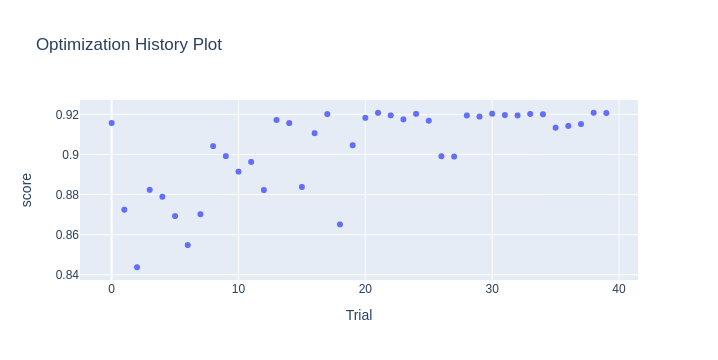

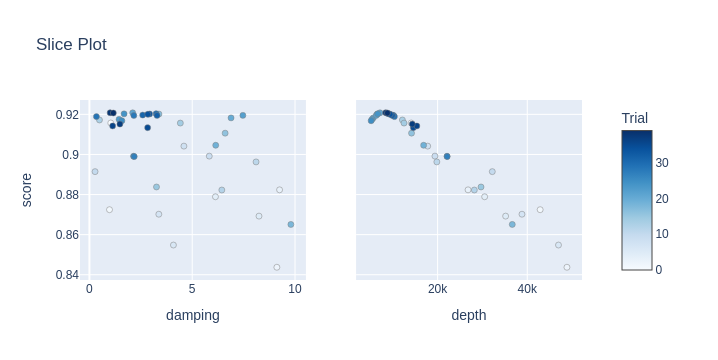

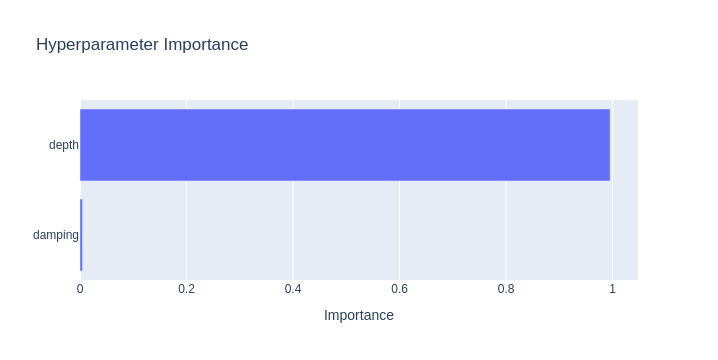

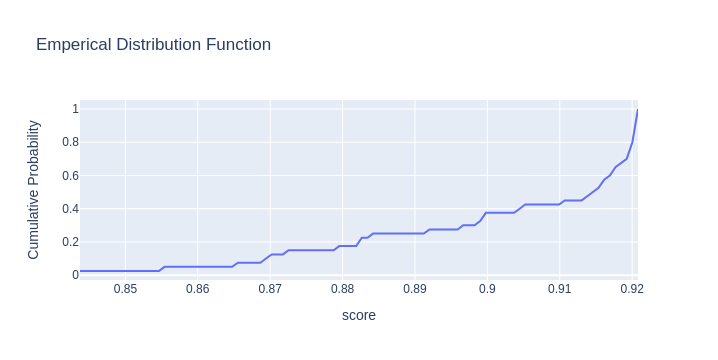

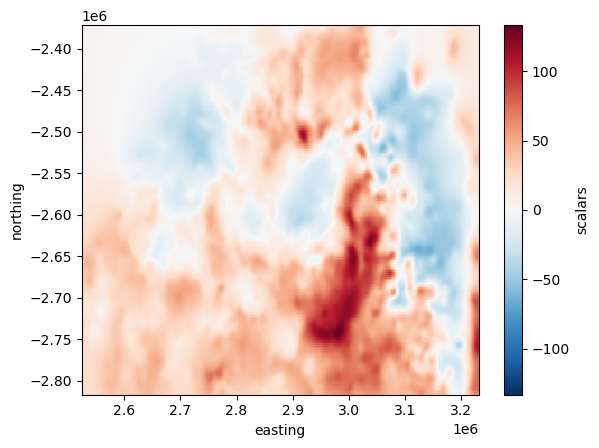

In [10]:
study_df, eqs = utils.optimize_eq_source_params(
    coordinates, 
    data.gravity_disturbance_mgal,
    n_trials=40,
    damping_limits = [0, 10],
    depth_limits = [5e3, 50e3],

    plot=True,
    parallel=True,
    # use_existing=True,
    # fname = f"../optimization_logs/test",
)
# Define grid coordinates
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=2e3,
    extra_coords=2.5e3,
)

grid_optim = eqs.grid(grid_coords)
grid_optim.scalars.plot()

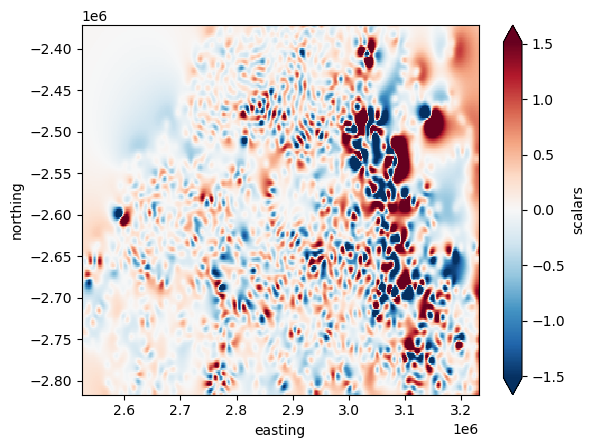

In [11]:
(grid.scalars - grid_optim.scalars).plot(robust=True)